<a href="https://colab.research.google.com/github/minjaekim070/Study/blob/main/Industry_Energy_Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Energy Consumption dataset 분석
Reference - https://www.kaggle.com/code/siddharthgoradia/steel-industry-energy-consumption-prediction

#데이터 업로드



In [1]:
#google drive 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#데이터 압축해제
!unzip /content/drive/MyDrive/Steel_Industry_Energy_Consumption.zip

Archive:  /content/drive/MyDrive/Steel_Industry_Energy_Consumption.zip
  inflating: Steel_industry_data.csv  


#라이브러리

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error as mse
from tensorflow import keras
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

#데이터 시각화

In [5]:
#데이터 불러오기
df = pd.read_csv('/content/Steel_industry_data.csv')

In [6]:
#데이터 열 종류 확인
print(df.columns)

Index(['date', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'Load_Type'],
      dtype='object')


In [7]:
#date -> day, month, year
df['day'] = pd.to_datetime(df['date']).dt.day
df['month'] = pd.to_datetime(df['date']).dt.month
df['year'] = pd.to_datetime(df['date']).dt.year

In [8]:
#data 확인
df.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type,day,month,year
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load,1,1,2018
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load,1,1,2018
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load,1,1,2018
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load,1,1,2018
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load,1,1,2018


In [9]:
#WeekStatus 열을 이용해서 평일/주말 별 Usage_kWh, Lagging_Current_Reactive.Power_kVarh 분석

# 평일/주말 기준으로 그룹화하여 평균 구하기
usage_kwh_mean = df.groupby('WeekStatus')['Usage_kWh'].mean()
lagging_current_mean = df.groupby('WeekStatus')['Lagging_Current_Reactive.Power_kVarh'].mean()

# 출력
print("평일 / 주말 Usage_kWh 평균:")
print(usage_kwh_mean['Weekday'], '/', usage_kwh_mean['Weekend'])

print("\n평일 / 주말 Lagging_Current_Reactive.Power_kVarh 평균:")
print(lagging_current_mean['Weekday'],'/',lagging_current_mean['Weekend'])

평일 / 주말 Usage_kWh 평균:
33.62472701149425 / 11.73232672275641

평일 / 주말 Lagging_Current_Reactive.Power_kVarh 평균:
16.32777019476373 / 4.772759415064103


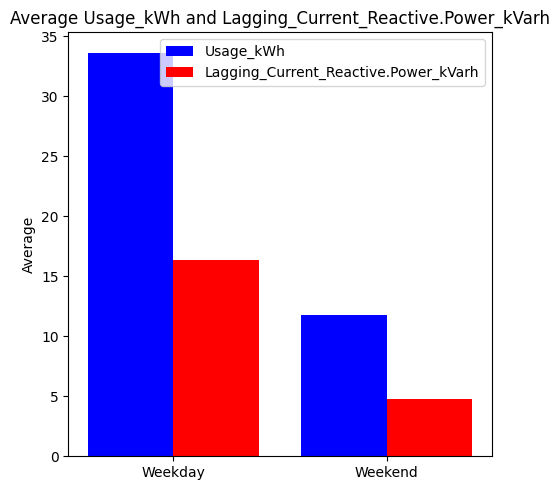

In [21]:
# 요일별 그룹화하여 평균 구하기
usage_kwh_mean = df.groupby('WeekStatus')['Usage_kWh'].mean()
lagging_current_mean = df.groupby('WeekStatus')['Lagging_Current_Reactive.Power_kVarh'].mean()

# 시각화
plt.figure(figsize=(5, 5))

# 두 바를 겹쳐서 표시하기 위해 width를 0.4로 설정
width = 0.4

# Usage_kWh 그래프
x = np.arange(len(usage_kwh_mean.index))
plt.bar(x, usage_kwh_mean, width=width, color='blue', label='Usage_kWh')

# Lagging_Current_Reactive.Power_kVarh 그래프
plt.bar(x + width, lagging_current_mean, width=width, color='red', label='Lagging_Current_Reactive.Power_kVarh')

# x축에 요일 이름 표시
plt.xticks(x + width/2, usage_kwh_mean.index)

plt.title('Average Usage_kWh and Lagging_Current_Reactive.Power_kVarh')
plt.ylabel('Average')
plt.legend()

plt.tight_layout()
plt.show()

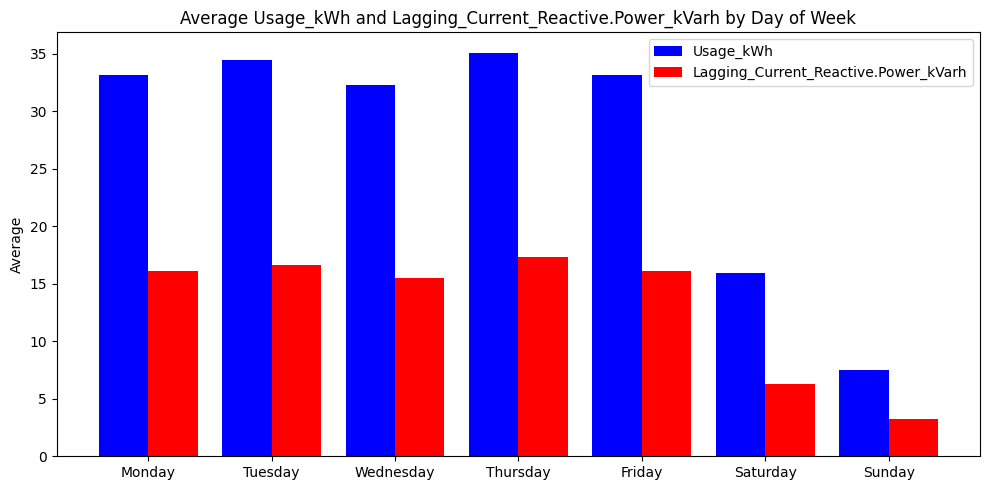

In [20]:
# 월요일부터 일요일까지의 순서로 정렬
df['Day_of_week_organized'] = pd.Categorical(df['Day_of_week'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
df = df.sort_values('Day_of_week_organized')

# 월요일부터 일요일까지의 순서로 정렬
df['Day_of_week_organized'] = pd.Categorical(df['Day_of_week'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
df = df.sort_values('Day_of_week_organized')

# 요일별 그룹화하여 평균 구하기
usage_kwh_mean = df.groupby('Day_of_week_organized')['Usage_kWh'].mean()
lagging_current_mean = df.groupby('Day_of_week_organized')['Lagging_Current_Reactive.Power_kVarh'].mean()

# 시각화
plt.figure(figsize=(10, 5))

# 두 바를 겹쳐서 표시하기 위해 width를 0.4로 설정
width = 0.4

# Usage_kWh 그래프
x = np.arange(len(usage_kwh_mean.index))
plt.bar(x, usage_kwh_mean, width=width, color='blue', label='Usage_kWh')

# Lagging_Current_Reactive.Power_kVarh 그래프
plt.bar(x + width, lagging_current_mean, width=width, color='red', label='Lagging_Current_Reactive.Power_kVarh')

# x축에 요일 이름 표시
plt.xticks(x + width/2, usage_kwh_mean.index)

plt.title('Average Usage_kWh and Lagging_Current_Reactive.Power_kVarh by Day of Week')
plt.ylabel('Average')
plt.legend()

plt.tight_layout()
plt.show()

Average Usage_kWH 와 Lagging_Current_Reactive_power_kVarh 값 모두 주중보다 주말에 적고 특히 일요일이 가장 적은 것으로 나타남


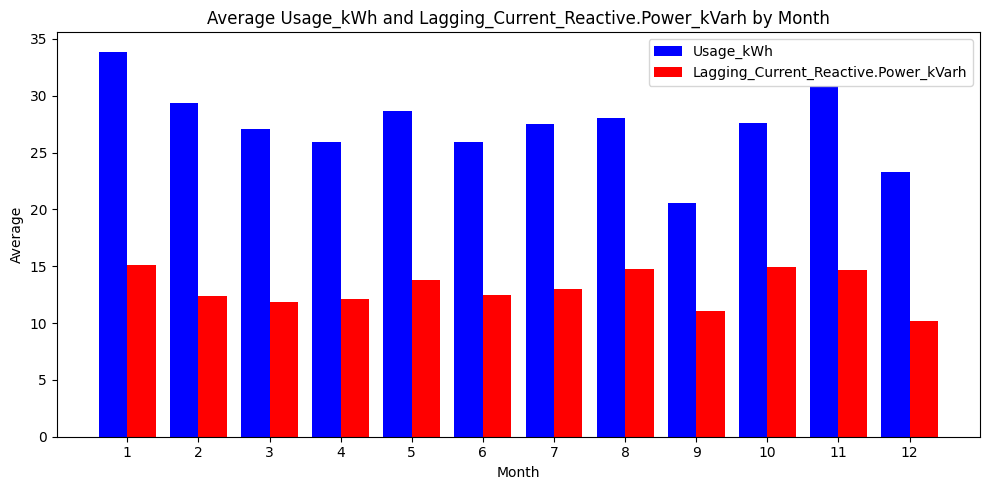

In [25]:
# 월별 그룹화하여 평균 구하기
usage_kwh_mean = df.groupby('month')['Usage_kWh'].mean()
lagging_current_mean = df.groupby('month')['Lagging_Current_Reactive.Power_kVarh'].mean()

# 시각화
plt.figure(figsize=(10, 5))

# 두 바를 겹쳐서 표시하기 위해 width를 0.4로 설정
width = 0.4

# Usage_kWh 그래프
x = np.arange(len(usage_kwh_mean.index))
plt.bar(x, usage_kwh_mean, width=width, color='blue', label='Usage_kWh')

# Lagging_Current_Reactive.Power_kVarh 그래프
plt.bar(x + width, lagging_current_mean, width=width, color='red', label='Lagging_Current_Reactive.Power_kVarh')

# x축에 요일 이름 표시
plt.xticks(x + width/2, usage_kwh_mean.index)

plt.title('Average Usage_kWh and Lagging_Current_Reactive.Power_kVarh by Month')
plt.xlabel('Month')
plt.ylabel('Average')
plt.legend()

plt.tight_layout()
plt.show()

월별로 약간의 차이는 있지만 명확하지는 않음.

<ipython-input-31-3a9bdfc592d0>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_new.corr(), annot = True, cmap = 'YlGnBu')


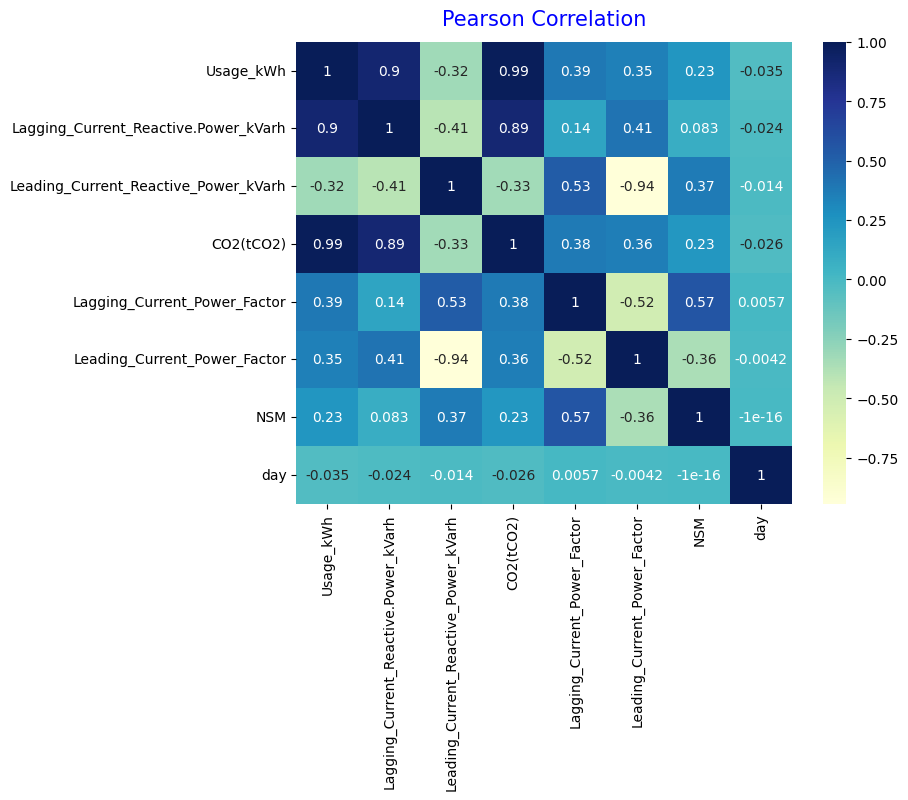

In [31]:
df_new = df.drop(['month', 'year'], axis=1)
plt.figure(figsize = (8,6))
sns.heatmap(df_new.corr(), annot = True, cmap = 'YlGnBu')
plt.title("Pearson Correlation", fontsize = 15, color = 'b', pad = 12, loc = 'center')
plt.show()

#데이터 전처리

In [26]:
print(df.columns)

Index(['date', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'Load_Type', 'day', 'month', 'year',
       'Day_of_week_organized'],
      dtype='object')
